In [1]:
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumCircuit, Qubit, Instruction, Operation, CircuitInstruction
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile

from circuit_knitting.cutting import partition_problem, cut_gates, cut_wires

from cutter_search_manual import *
from resource_analysis import PhysicalParameters
from automation import *

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * np.sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * np.cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [3]:
from azure.quantum import Workspace
workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider(workspace)
backend_est = provider.get_backend('microsoft.estimator')

In [3]:
# second_order_formula = SuzukiTrotter()

# L = 3
# H = get_hamiltonian(L=L, J=0.2, h=1.0, alpha=np.pi / 8)
# final_time = np.pi
# num_timesteps = 10
# dt = final_time / num_timesteps
# initial_state = Statevector.from_label("000")

# trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
# circuit = QuantumCircuit(H.num_qubits)
# for i in range(1):
#     circuit.append(trotter_step_second_order, range(H.num_qubits))
# # circuit = circuit.decompose(reps=1)
# target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
# circuit = transpile(circuit,
#                        basis_gates=target_basis, 
#                        optimization_level=1) 

# # Let us print some stats
# print(
#     f"""
# Trotter step with Suzuki Trotter (2nd order)
# --------------------------------------------

#                   Depth: {circuit.depth()}
#              Gate count: {len(circuit)}
#     Nonlocal gate count: {circuit.num_nonlocal_gates()}
#          Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

# """
# )
# print(H)

# circuit.draw("mpl")

In [4]:
# for ins in circuit.data:
#     print(ins)

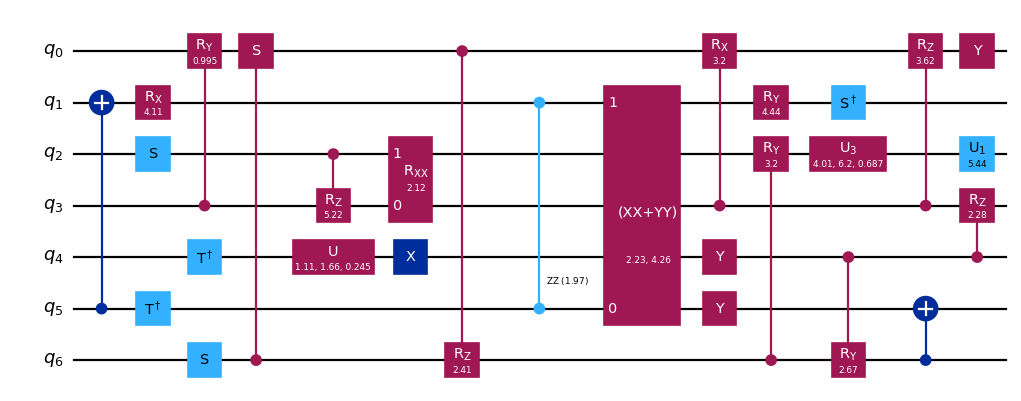

In [2]:
from qiskit.circuit.random import random_circuit
circuit = random_circuit(7, 6, max_operands=2, seed=1242)
circuit.draw('mpl', scale=0.8)

# Need two cut for one c-rot gate with bell pair? Difficult to locate...

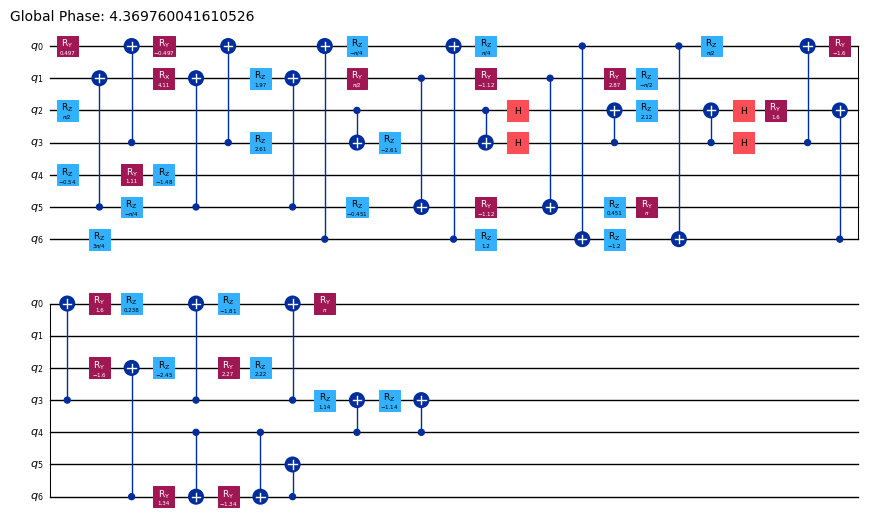

In [7]:
target_basis = ['rx', 'ry', 'rz', 'h', 'cx']
transpile_circ = transpile(circuit,
                       basis_gates=target_basis, 
                       optimization_level=1) 
transpile_circ.draw('mpl', scale=0.5)

In [8]:
# from qiskit.converters import circuit_to_dag, dag_to_circuit
# dag = circuit_to_dag(transpile_circ)
# for layer in dag.layers():
#     layer_as_circuit = dag_to_circuit(layer['graph'])
#     for _inst in layer_as_circuit.data:
#         print(_inst.operation.name, [qubit._index for qubit in  _inst.qubits])

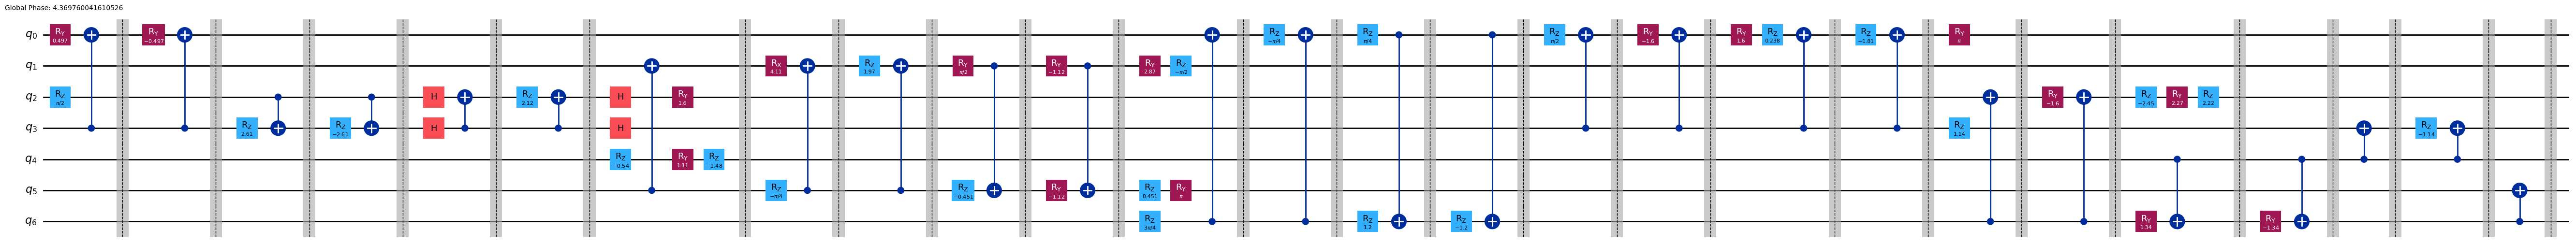

In [9]:
from qiskit.circuit import CircuitInstruction
from qiskit.circuit.library import Barrier

_len = len(transpile_circ.data)
for index, _instr in enumerate(reversed(transpile_circ.data)):
    if _instr.operation.name == 'cx':
        transpile_circ.data.insert(_len - index, CircuitInstruction(Barrier(transpile_circ.num_qubits), range(transpile_circ.num_qubits)))

transpile_circ.draw('mpl', fold=-1)

In [10]:
loc = {21,23,24}
count = 0
ins_id = 0
p = True
for ins in transpile_circ.data:
    if ins.operation.name == 'barrier':
        count += 1
        p = True
    if count in loc and p == True:
        print(ins_id)
        p = False
    ins_id += 1
print(count)

79
88
90
26


In [11]:
from qiskit.transpiler.passes import RemoveBarriers
subcirc_transpile, ancilla = bell_cuts(RemoveBarriers()(transpile_circ),[89-23,92-24],{84-21:[6]}, True)

Found solution using 3 cuts with a samplingoverhead of 1296.
Wire Cut at circuit instruction index 63
Gate Cut at circuit instruction index 67
Gate Cut at circuit instruction index 69


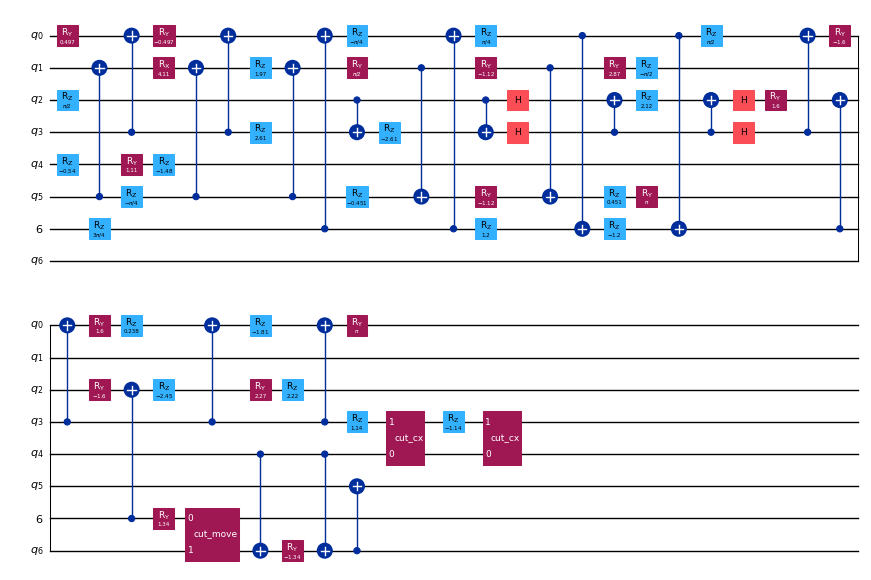

In [12]:
ancilla.draw('mpl', scale=0.5)

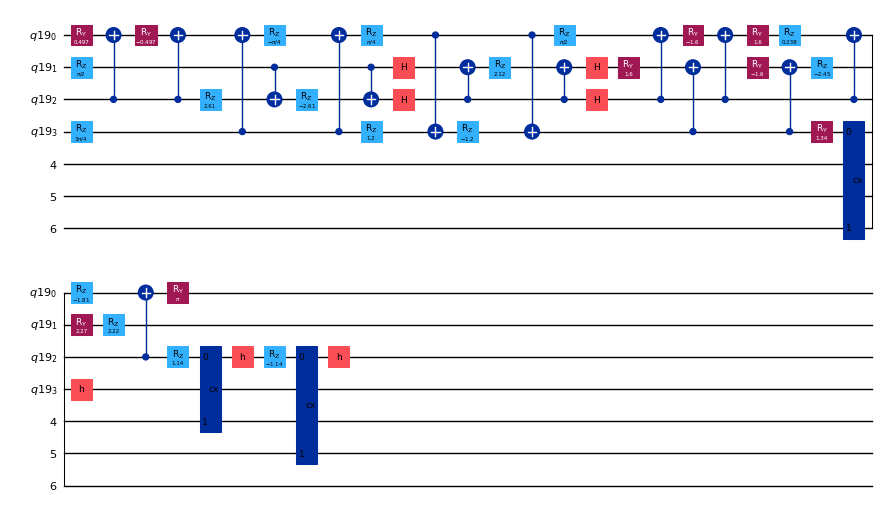

In [13]:
subcirc_transpile[0].draw('mpl', scale=0.5)

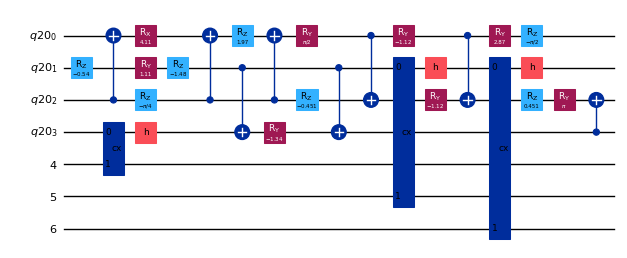

In [14]:
subcirc_transpile[1].draw('mpl', scale=0.5)

In [15]:
job_t = backend_est.run(transpile_circ)
result_t = job_t.result()
result_t

......

Runtime,880 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 200 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,5.23M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (23) (with a logical error rate of 7.25e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,305.65k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 5,566 physical qubits to implement the algorithm logic, and 300,080 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,23,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 7$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 23$ logical qubits."
Algorithmic depth,200,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 31 arbitrary single-qubit rotations, and the 4 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 15 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,200,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 200. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,469,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 4 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 15 for each of the 31 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,31,"Number of T factories capable of producing the demanded 469 T states during the algorithm's runtime The total number of T factories 31 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{469 \cdot 57,200\;\text{ns}}{1 \cdot 880,000\;\text{ns}}\right\rceil$"
Number of T factory invocations,16,"Number of times all T factories are invoked In order to prepare the 469 T states, the 31 copies of the T factory are repeatedly invoked 16 times."
Physical algorithmic qubits,5.57k,"Number of physical qubits for the algorithm after layout The 5,566 are the product of the 23 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [16]:
jobA_t = backend_est.run(map_subcirc(subcirc_transpile[0]))
resultA_t = jobA_t.result()
resultA_t

.......

Runtime,774 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 176 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,5.23M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (23) (with a logical error rate of 8.23e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,199.17k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 5,566 physical qubits to implement the algorithm logic, and 193,600 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,23,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 7$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 23$ logical qubits."
Algorithmic depth,176,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 19 arbitrary single-qubit rotations, and the 3 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,176,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 176. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,269,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 3 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 19 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,20,"Number of T factories capable of producing the demanded 269 T states during the algorithm's runtime The total number of T factories 20 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{269 \cdot 57,200\;\text{ns}}{1 \cdot 774,400\;\text{ns}}\right\rceil$"
Number of T factory invocations,14,"Number of times all T factories are invoked In order to prepare the 269 T states, the 20 copies of the T factory are repeatedly invoked 14 times."
Physical algorithmic qubits,5.57k,"Number of physical qubits for the algorithm after layout The 5,566 are the product of the 23 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [17]:
jobB_t = backend_est.run(map_subcirc(subcirc_transpile[1]))
resultB_t = jobB_t.result()
resultB_t

.....

Runtime,427 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 97 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,5.23M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (23) (with a logical error rate of 1.49e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,228.21k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 5,566 physical qubits to implement the algorithm logic, and 222,640 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,23,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 7$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 23$ logical qubits."
Algorithmic depth,97,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 12 arbitrary single-qubit rotations, and the 1 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 6 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,97,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 97. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,169,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 1 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 12 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,23,"Number of T factories capable of producing the demanded 169 T states during the algorithm's runtime The total number of T factories 23 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{169 \cdot 57,200\;\text{ns}}{1 \cdot 426,800\;\text{ns}}\right\rceil$"
Number of T factory invocations,8,"Number of times all T factories are invoked In order to prepare the 169 T states, the 23 copies of the T factory are repeatedly invoked 8 times."
Physical algorithmic qubits,5.57k,"Number of physical qubits for the algorithm after layout The 5,566 are the product of the 23 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


# Bell cut, which is wrong

In [3]:
subcirc = bell_cuts(circuit,[27],{19:[6]})

Found solution using 2 cuts with a samplingoverhead of 144.
Wire Cut at circuit instruction index 19
Gate Cut at circuit instruction index 28


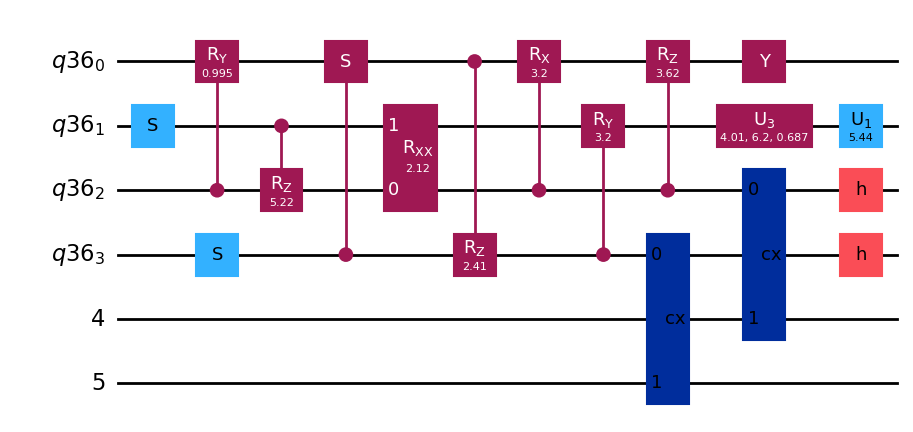

In [19]:
subcirc[0].draw('mpl')

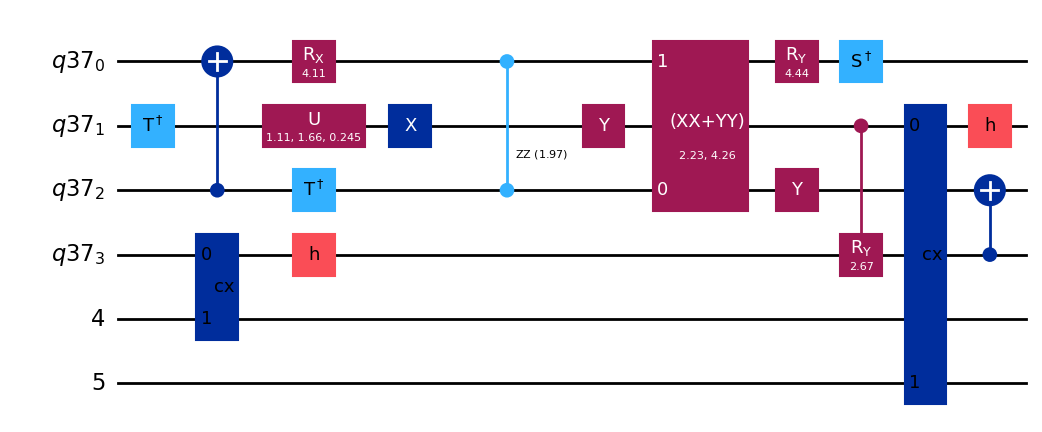

In [20]:
subcirc[1].draw('mpl')

In [22]:
job = backend_est.run(circuit)
result = job.result()
result

......

Runtime,884 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 201 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,5.23M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (23) (with a logical error rate of 7.21e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,305.65k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 5,566 physical qubits to implement the algorithm logic, and 300,080 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,23,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 7$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 23$ logical qubits."
Algorithmic depth,201,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 31 arbitrary single-qubit rotations, and the 5 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 15 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,201,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 201. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,470,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 5 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 15 for each of the 31 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,31,"Number of T factories capable of producing the demanded 470 T states during the algorithm's runtime The total number of T factories 31 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{470 \cdot 57,200\;\text{ns}}{1 \cdot 884,400\;\text{ns}}\right\rceil$"
Number of T factory invocations,16,"Number of times all T factories are invoked In order to prepare the 470 T states, the 31 copies of the T factory are repeatedly invoked 16 times."
Physical algorithmic qubits,5.57k,"Number of physical qubits for the algorithm after layout The 5,566 are the product of the 23 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [23]:
jobA = backend_est.run(map_subcirc(subcirc[0]))
resultA = jobA.result()
resultA

.....

Runtime,766 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 174 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,4.55M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (20) (with a logical error rate of 9.58e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,188.76k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 4,840 physical qubits to implement the algorithm logic, and 183,920 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,20,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 6$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 20$ logical qubits."
Algorithmic depth,174,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 17 arbitrary single-qubit rotations, and the 3 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,174,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 174. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,241,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 3 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 17 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,19,"Number of T factories capable of producing the demanded 241 T states during the algorithm's runtime The total number of T factories 19 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{241 \cdot 57,200\;\text{ns}}{1 \cdot 765,600\;\text{ns}}\right\rceil$"
Number of T factory invocations,13,"Number of times all T factories are invoked In order to prepare the 241 T states, the 19 copies of the T factory are repeatedly invoked 13 times."
Physical algorithmic qubits,4.84k,"Number of physical qubits for the algorithm after layout The 4,840 are the product of the 20 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [24]:
jobB = backend_est.run(map_subcirc(subcirc[1]))
resultB = jobB.result()
resultB

......

Runtime,370 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 84 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,4.55M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (20) (with a logical error rate of 1.98e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,266.20k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 4,840 physical qubits to implement the algorithm logic, and 261,360 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,20,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 6$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 20$ logical qubits."
Algorithmic depth,84,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 12 arbitrary single-qubit rotations, and the 2 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 5 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,84,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 84. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,170,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 2 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 12 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,27,"Number of T factories capable of producing the demanded 170 T states during the algorithm's runtime The total number of T factories 27 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{170 \cdot 57,200\;\text{ns}}{1 \cdot 369,600\;\text{ns}}\right\rceil$"
Number of T factory invocations,7,"Number of times all T factories are invoked In order to prepare the 170 T states, the 27 copies of the T factory are repeatedly invoked 7 times."
Physical algorithmic qubits,4.84k,"Number of physical qubits for the algorithm after layout The 4,840 are the product of the 20 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


# Error budget allocation?

In [ ]:
# from qsharp.estimator import EstimatorParams

# params = EstimatorParams()
# params.error_budget.logical = 0.1/3
# params.error_budget.t_states = 0.1/3
# params.error_budget.rotations = 0.1/3

# Decomposition

Found solution using 2 cuts with a samplingoverhead of 127.06026169907257.
Wire Cut at circuit instruction index 19
Gate Cut at circuit instruction index 28


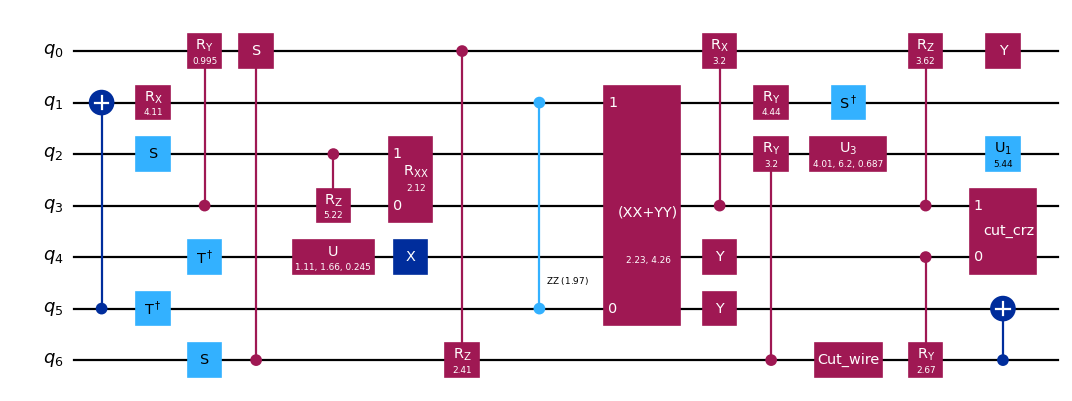

In [4]:
cut_circuit_dp, metadata = cuts(circuit,[27],{19:[6]})
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling'
    
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit_dp.draw("mpl", scale=0.8, fold=-1)

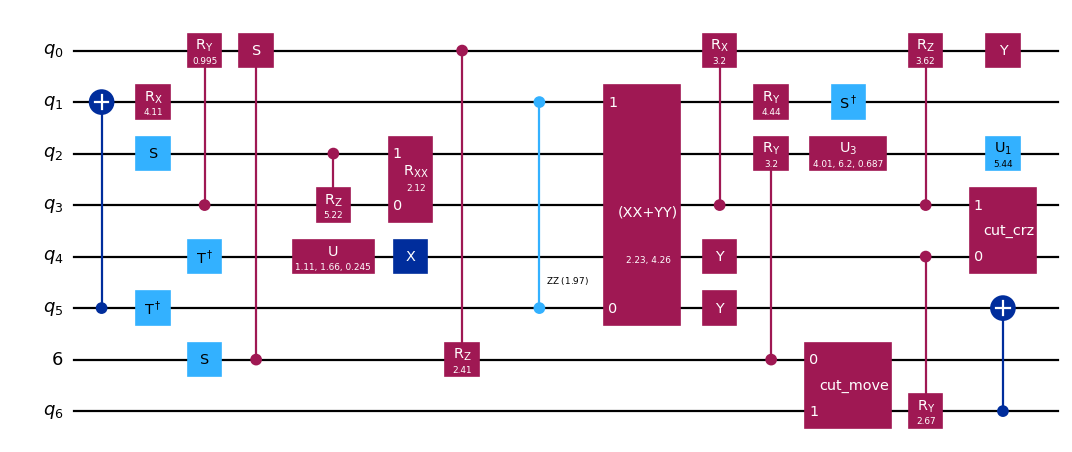

In [5]:
qc_w_ancilla_dp = cut_wires(cut_circuit_dp)
qc_w_ancilla_dp.draw("mpl", scale=0.8, fold=-1)

In [6]:
partitioned_problem_dp = partition_problem(circuit=qc_w_ancilla_dp)
subcircuits_dp = partitioned_problem_dp.subcircuits
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem_dp.bases])}"
)

Sampling overhead: 127.06026169907257


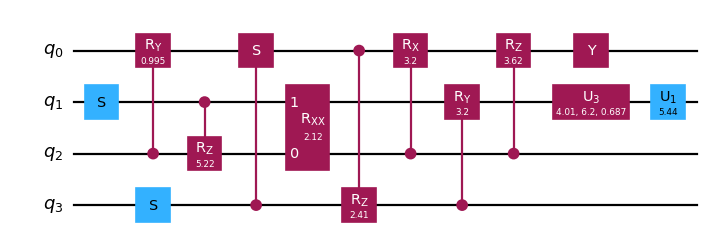

In [7]:
s_dp1 = map_subcirc(subcircuits_dp[0],True)
s_dp1.draw("mpl", scale=0.8)

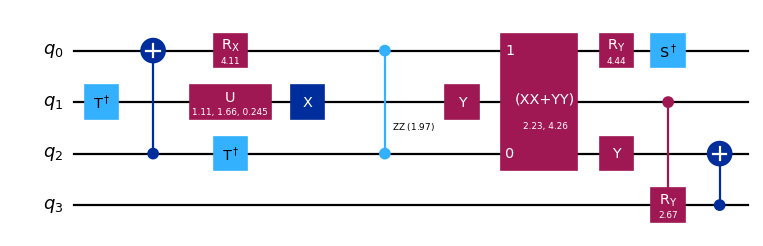

In [8]:
s_dp2 = map_subcirc(subcircuits_dp[1],True)
s_dp2.draw("mpl", scale=0.8)

In [10]:
job_d = backend_est.run(circuit)
result_d = job_d.result()
result_d

......

Runtime,884 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 201 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,5.23M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (23) (with a logical error rate of 7.21e-8) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,305.65k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 5,566 physical qubits to implement the algorithm logic, and 300,080 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,23,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 7$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 23$ logical qubits."
Algorithmic depth,201,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 31 arbitrary single-qubit rotations, and the 5 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 15 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,201,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 201. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,470,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 5 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 15 for each of the 31 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,31,"Number of T factories capable of producing the demanded 470 T states during the algorithm's runtime The total number of T factories 31 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{470 \cdot 57,200\;\text{ns}}{1 \cdot 884,400\;\text{ns}}\right\rceil$"
Number of T factory invocations,16,"Number of times all T factories are invoked In order to prepare the 470 T states, the 31 copies of the T factory are repeatedly invoked 16 times."
Physical algorithmic qubits,5.57k,"Number of physical qubits for the algorithm after layout The 5,566 are the product of the 23 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [11]:
job_d1 = backend_est.run(s_dp1)
result_d1 = job_d1.result()
result_d1

......

Runtime,766 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 174 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.41M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 1.28e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,187.55k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 183,920 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,174,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 17 arbitrary single-qubit rotations, and the 3 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 11 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,174,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 174. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,241,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 3 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 17 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,19,"Number of T factories capable of producing the demanded 241 T states during the algorithm's runtime The total number of T factories 19 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{241 \cdot 57,200\;\text{ns}}{1 \cdot 765,600\;\text{ns}}\right\rceil$"
Number of T factory invocations,13,"Number of times all T factories are invoked In order to prepare the 241 T states, the 19 copies of the T factory are repeatedly invoked 13 times."
Physical algorithmic qubits,3.63k,"Number of physical qubits for the algorithm after layout The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."


In [12]:
job_d2 = backend_est.run(s_dp2)
result_d2 = job_d2.result()
result_d2

......

Runtime,370 microsecs,"Total runtime This is a runtime estimate for the execution time of the algorithm. In general, the execution time corresponds to the duration of one logical cycle (4,400 nanosecs) multiplied by the 84 logical cycles to run the algorithm. If however the duration of a single T factory (here: 57,200 nanosecs) is larger than the algorithm runtime, we extend the number of logical cycles artificially in order to exceed the runtime of a single T factory."
rQOPS,3.41M,"Reliable quantum operations per second The value is computed as the number of logical qubits after layout (15) (with a logical error rate of 2.65e-7) multiplied by the clock frequency (227,272.73), which is the number of logical cycles per second."
Physical qubits,264.99k,"Number of physical qubits This value represents the total number of physical qubits, which is the sum of 3,630 physical qubits to implement the algorithm logic, and 261,360 physical qubits to execute the T factories that are responsible to produce the T states that are consumed by the algorithm."
Logical algorithmic qubits,15,"Number of logical qubits for the algorithm after layout Laying out the logical qubits in the presence of nearest-neighbor constraints requires additional logical qubits. In particular, to layout the $Q_{\rm alg} = 4$ logical qubits in the input algorithm, we require in total $2 \cdot Q_{\rm alg} + \lceil \sqrt{8 \cdot Q_{\rm alg}}\rceil + 1 = 15$ logical qubits."
Algorithmic depth,84,"Number of logical cycles for the algorithm To execute the algorithm using Parallel Synthesis Sequential Pauli Computation (PSSPC), operations are scheduled in terms of multi-qubit Pauli measurements, for which assume an execution time of one logical cycle. Based on the input algorithm, we require one multi-qubit measurement for the 0 single-qubit measurements, the 12 arbitrary single-qubit rotations, and the 2 T gates, three multi-qubit measurements for each of the 0 CCZ and 0 CCiX gates in the input program, as well as 14 multi-qubit measurements for each of the 5 non-Clifford layers in which there is at least one single-qubit rotation with an arbitrary angle rotation."
Logical depth,84,"Number of logical cycles performed This number is usually equal to the logical depth of the algorithm, which is 84. However, in the case in which a single T factory is slower than the execution time of the algorithm, we adjust the logical cycle depth to exceed the T factory's execution time."
Clock frequency,227.27k,Number of logical cycles per second This is the number of logical cycles that can be performed within one second. The logical cycle time is 4 microsecs.
Number of T states,170,"Number of T states consumed by the algorithm To execute the algorithm, we require one T state for each of the 2 T gates, four T states for each of the 0 CCZ and 0 CCiX gates, as well as 14 for each of the 12 single-qubit rotation gates with arbitrary angle rotation."
Number of T factories,27,"Number of T factories capable of producing the demanded 170 T states during the algorithm's runtime The total number of T factories 27 that are executed in parallel is computed as $\left\lceil\dfrac{\text{T states}\cdot\text{T factory duration}}{\text{T states per T factory}\cdot\text{algorithm runtime}}\right\rceil = \left\lceil\dfrac{170 \cdot 57,200\;\text{ns}}{1 \cdot 369,600\;\text{ns}}\right\rceil$"
Number of T factory invocations,7,"Number of times all T factories are invoked In order to prepare the 170 T states, the 27 copies of the T factory are repeatedly invoked 7 times."
Physical algorithmic qubits,3.63k,"Number of physical qubits for the algorithm after layout The 3,630 are the product of the 15 logical qubits after layout and the 242 physical qubits that encode a single logical qubit."
